In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

# `panco2` example: Pressure profile of a mock cluster from a mock NIKA2 map

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
import scipy.stats as ss

In [3]:
import sys
sys.path.append("..")
import panco2 as p2

This presents the pressure profile extraction from the NIKA2 map of the C2 cluster, presented in the validation paper.
The C2 cluster is a mock source with $z=0.5, \; M_{500} = 6 \times 10^{14} M_\odot$, with an Arnaud et al. (2010) universal pressure profile.
The NIKA2 map is projected using a gnomonic projection in (RA, dec), on a $6.5'$ square, with $3''$ pixels.
The noise is white, with an RMS map taken from NIKA2 ACTJ0215 observations.
The beam is gaussian with $18''$ FWHM, and we use a smoothed version of the transfer function of Kéruzoré et al. (2020).

## Initialization

Start by reading in the data, giving cluster info, and the size and center of the map to be considered for the fit:

In [4]:
path = "."
ppf = p2.PressureProfileFitter(
    f"{path}/input_map.fits",
    1, 5,
    0.5, 6e14,
    map_size=6.5,
    coords_center=SkyCoord("12h00m00s +00d00m00s")
)

Then we define the radial binning to be used for the fit.
The first bin is defined as the projected radius corresponding to the size of a map pixel, $R_0 = \mathcal{D}_{\rm A}(z) \tan^{-1} \theta_{\rm pix}$, where $\mathcal{D}_{\rm A}(z)$ is the angular diameter distance to the cluster redshift $z$.
Four bins $\left\{R_1 \dots R_4 \right\}$ are then added, log-spaced between the projected sizes of the beam FWHM, $\mathcal{D}_{\rm A}(z) \tan^{-1} \theta_{\rm FWHM}$, and of the half map size, $\mathcal{D}_{\rm A}(z) \tan^{-1} \theta_{\rm map} / 2$.

In [5]:

pix_kpc, half_map_kpc = ppf.cluster.arcsec2kpc(ppf.pix_size), ppf.cluster.arcsec2kpc(ppf.map_size * 60 / 2)
beam_kpc = ppf.cluster.arcsec2kpc(18.0)
r_bins = np.concatenate(([pix_kpc], np.logspace(np.log10(beam_kpc), np.log10(1.1 * half_map_kpc), 4)))

ppf.define_model(r_bins)


Add filtering: $18''$ beam, NIKA2-like transfer function

In [6]:
tf = np.load(f"{path}/nk2_tf.npz")
ppf.add_filtering(beam_fwhm=18.0, ell=tf["ell"], tf=tf["tf_150GHz"], pad=20)

Adding filtering: beam and 1D transfer function


Priors: log-uniform centered on A10 values for pressure bins, Gaussian for the conversion and zero-level

In [7]:
P_bins = p2.utils.gNFW(r_bins, *ppf.cluster.A10_params)
ppf.define_priors(
    P_bins=[ss.loguniform(0.01 * P, 100.0 * P) for P in P_bins],
    conv=ss.norm(-12.0, 1.2),
    zero=ss.norm(0.0, 1e-4)
)

The main `PressureProfileFitter` object can be pickled and saved. 
This contains all the information loaded in the class (data, analysis choices, model computing functions, etc).

In [8]:
ppf.dump_to_file(f"{path}/panco2.dill")

This means you can load up this saved file and not have to redo all the initialization steps, or just check the options that were used; it's a good tool for tracability.
To do that, use:

In [9]:
# ppf = p2.PressureProfileFitter.load_from_file(f"{path}/panco2.dill")

## Run the MCMC

This saves the raw chains, and a plot of the evolution of the autocorrelation towards convergence.
Green regions are where convergence gets accepted.
(I run more steps than for the validation described in the paper for better-looking plots)

I'll check convergence every 500 steps, and stop when the autocorrelation length `tau` has changed by less than 1.0% twice in a row, and the chain is longer than 100*tau


/Users/fkeruzore/.miniconda3/envs/panco2/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  1%|          | 502/50000 [00:29<53:26, 15.44it/s]

    500 iterations = 13.3*tau (tau = 37.5 -> dtau/tau = 1.0000)


  2%|▏         | 1002/50000 [00:58<49:29, 16.50it/s]

    1000 iterations = 15.7*tau (tau = 63.9 -> dtau/tau = 0.4122)


  3%|▎         | 1502/50000 [01:27<48:08, 16.79it/s]

    1500 iterations = 20.1*tau (tau = 74.5 -> dtau/tau = 0.1429)


  4%|▍         | 2002/50000 [01:56<47:04, 16.99it/s]

    2000 iterations = 26.4*tau (tau = 75.9 -> dtau/tau = 0.0181)


  5%|▌         | 2502/50000 [02:25<48:40, 16.26it/s]

    2500 iterations = 31.4*tau (tau = 79.5 -> dtau/tau = 0.0454)


  6%|▌         | 3002/50000 [02:53<47:56, 16.34it/s]

    3000 iterations = 36.2*tau (tau = 83.0 -> dtau/tau = 0.0419)


  7%|▋         | 3502/50000 [03:22<47:06, 16.45it/s]

    3500 iterations = 40.4*tau (tau = 86.6 -> dtau/tau = 0.0424)


  8%|▊         | 4002/50000 [03:50<46:10, 16.60it/s]

    4000 iterations = 44.5*tau (tau = 89.9 -> dtau/tau = 0.0364)


  9%|▉         | 4502/50000 [04:18<49:05, 15.45it/s]

    4500 iterations = 48.8*tau (tau = 92.2 -> dtau/tau = 0.0248)


 10%|█         | 5002/50000 [04:45<48:56, 15.32it/s]

    5000 iterations = 51.3*tau (tau = 97.5 -> dtau/tau = 0.0542)


 11%|█         | 5502/50000 [05:13<50:14, 14.76it/s]

    5500 iterations = 54.8*tau (tau = 100.3 -> dtau/tau = 0.0279)


 12%|█▏        | 6002/50000 [05:41<47:01, 15.60it/s]

    6000 iterations = 60.1*tau (tau = 99.8 -> dtau/tau = 0.0050)


 13%|█▎        | 6502/50000 [06:09<46:30, 15.59it/s]

    6500 iterations = 65.2*tau (tau = 99.7 -> dtau/tau = 0.0003)


 14%|█▍        | 7002/50000 [06:36<46:20, 15.46it/s]

    7000 iterations = 70.3*tau (tau = 99.6 -> dtau/tau = 0.0012)


 15%|█▌        | 7502/50000 [07:04<46:00, 15.39it/s]

    7500 iterations = 74.3*tau (tau = 100.9 -> dtau/tau = 0.0124)


 16%|█▌        | 8002/50000 [07:31<45:28, 15.39it/s]

    8000 iterations = 78.6*tau (tau = 101.8 -> dtau/tau = 0.0094)


 17%|█▋        | 8502/50000 [07:59<50:59, 13.56it/s]

    8500 iterations = 82.8*tau (tau = 102.7 -> dtau/tau = 0.0081)


 18%|█▊        | 9002/50000 [08:27<50:40, 13.49it/s]

    9000 iterations = 87.2*tau (tau = 103.2 -> dtau/tau = 0.0055)


 19%|█▉        | 9502/50000 [08:54<49:30, 13.63it/s]

    9500 iterations = 91.3*tau (tau = 104.0 -> dtau/tau = 0.0075)


 20%|██        | 10002/50000 [09:21<49:08, 13.57it/s]

    10000 iterations = 95.8*tau (tau = 104.3 -> dtau/tau = 0.0032)


 21%|██        | 10502/50000 [09:49<49:16, 13.36it/s]

    10500 iterations = 99.9*tau (tau = 105.1 -> dtau/tau = 0.0068)


 22%|██▏       | 11000/50000 [10:16<36:26, 17.84it/s]


    11000 iterations = 104.5*tau (tau = 105.3 -> dtau/tau = 0.0019)
    -> Convergence achieved
Running time: 00h10m17s


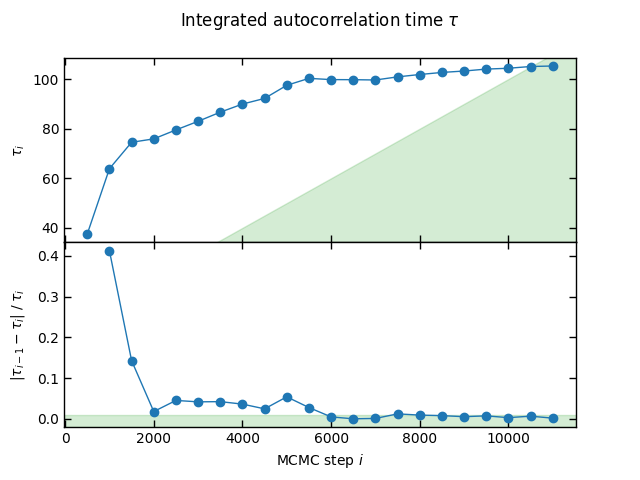

In [10]:
np.random.seed(42)
_ = ppf.run_mcmc(
    30, 5e4, 4, n_check=5e2, max_delta_tau=0.01, min_autocorr_times=100, 
    out_chains_file=f"{path}/rawchains.npz", plot_convergence=f"{path}/mcmc_convergence.pdf"
)

Clean up the raw chains:

In [11]:
chains_clean = p2.results.load_chains(f"{path}/rawchains.npz", 500, 50, clip_percent=20.0, verbose=True)

Raw length: 11000, clip 500 as burn-in, discard 49/50 samples  -> Final chains length: 210
30 walkers, remove chains with the 20.0% most extreme values  -> 30 chains remaining
-> Final sampling size: 30 chains * 210 samples per chain = 6300 total samples


## Plots

Chains plot and corner plot:

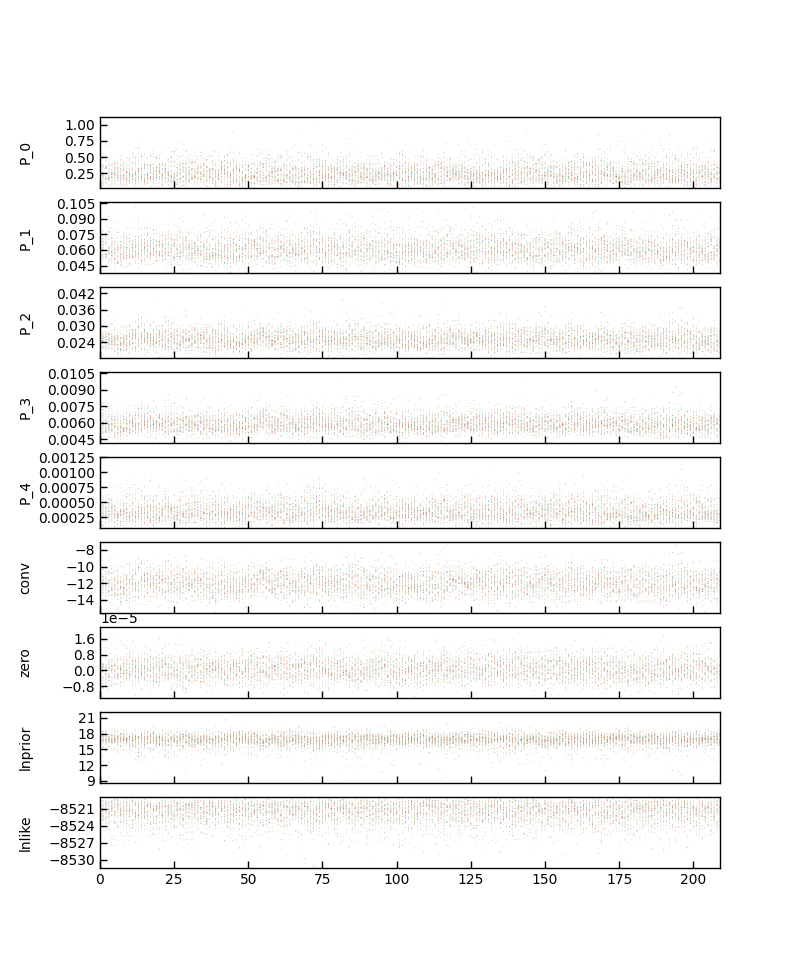

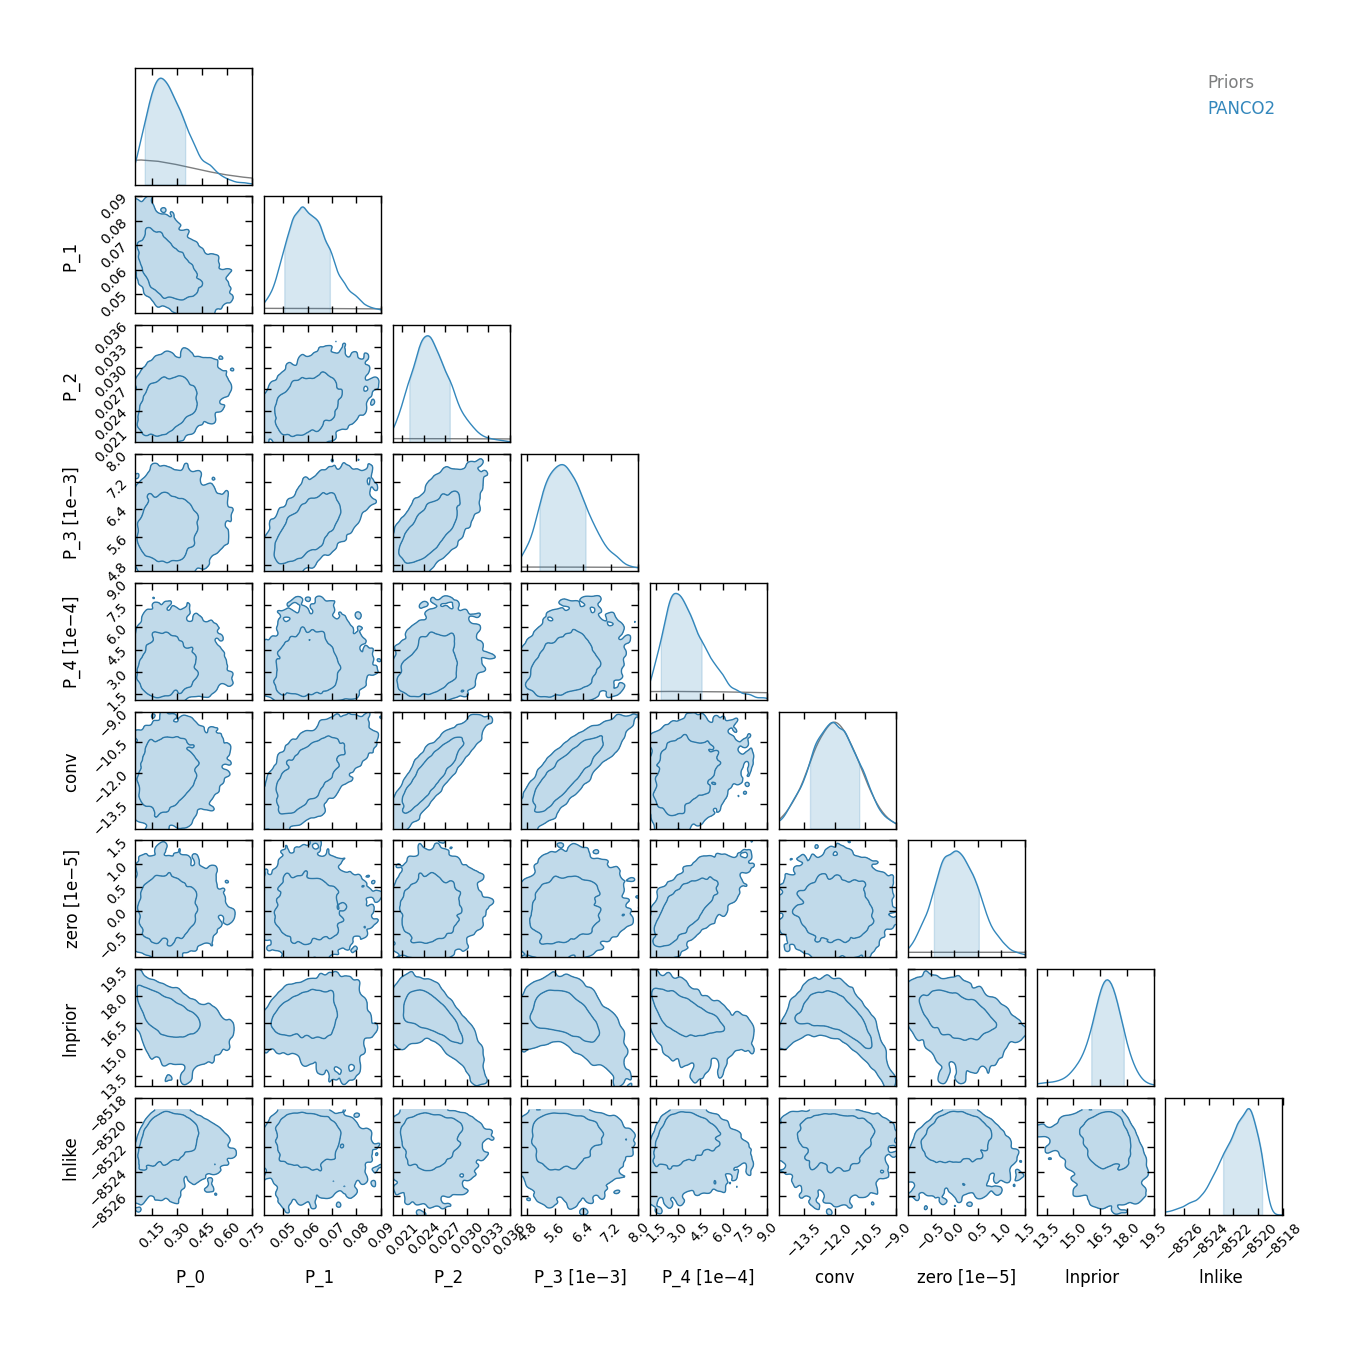

In [12]:
plt.close("all")
_ = p2.results.mcmc_trace_plot(chains_clean, filename=f"{path}/mcmc_trace.png")
_ = p2.results.mcmc_corner_plot(chains_clean, ppf=ppf, filename=f"{path}/mcmc_corner.pdf")

Correlation/covariance in the parameter space. The diagonal and upper triangle show the absolute value of the covariance between parameters (with the color map on the right), while the lower triangle show correlation values (with the color map on the bottom).

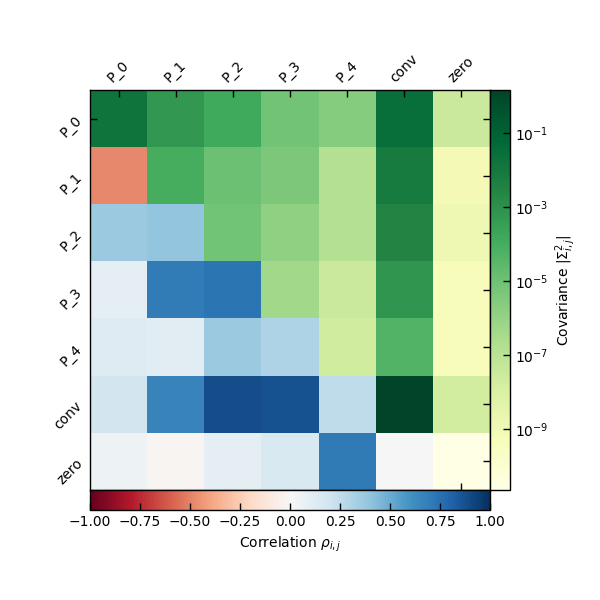

In [13]:
_ = p2.results.mcmc_matrices_plot(chains_clean, ppf, filename=f"{path}/mcmc_matrices.pdf")

Data-model-residuals: in 2D (plotting the model as the median of the posterior), and in 1D (computing a model and residuals map for each sample in the posterior, and showing 16th-84th percentiles)

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:xlabel='$\\theta \\; [{\\rm arcsec}]$', ylabel='NIKA2 150 GHz [mJy/beam]'>)

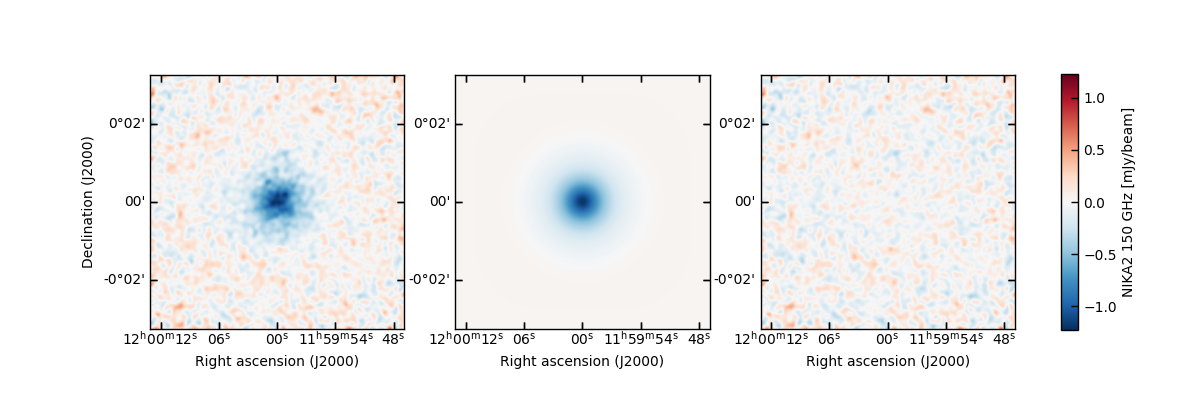

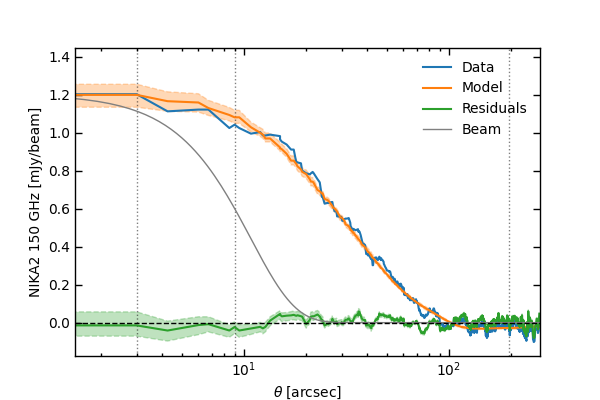

In [14]:
meds = dict(chains_clean.median())
p2.results.plot_data_model_residuals(
    ppf, par_dic=meds, smooth=1.0, cbar_fact=1e3, cmap="RdBu_r", lims="sym",
    cbar_label="NIKA2 150 GHz [mJy/beam]", filename=f"{path}/data_model_residuals_maps.pdf"
)
p2.results.plot_data_model_residuals_1d(
    ppf, chains_clean=chains_clean, y_fact=-1e3, plot_beam=True, 
    y_label="NIKA2 150 GHz [mJy/beam]", filename=f"{path}/data_model_residuals_profiles.pdf", x_log=True
)

Pressure profile

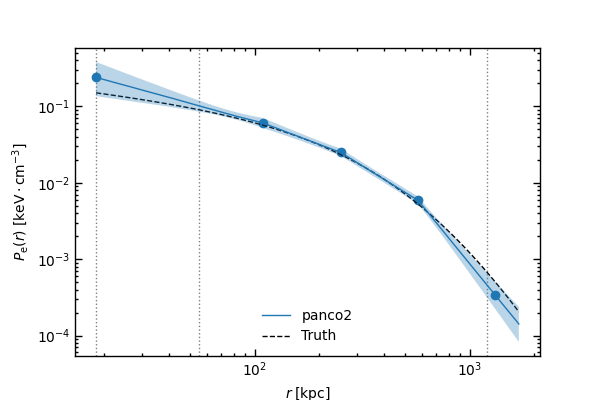

In [15]:
r_range = np.logspace(np.log10(ppf.cluster.arcsec2kpc(ppf.pix_size)), np.log10(ppf.cluster.arcsec2kpc(ppf.map_size * 60 / np.sqrt(2))), 100)
fig, ax = p2.results.plot_profile(chains_clean, ppf, r_range=r_range, label="panco2")
ax.plot(r_range, p2.utils.gNFW(r_range, *ppf.cluster.A10_params), "k--", label="Truth")
ax.legend(frameon=False)
fig.savefig(f"{path}/pressure_profile.pdf")